# `multidms` comparison with the naive approach

This notebook will perform the naive approach where conditions are fit separately, and their betas are simply subtracted

Note, this was run with [this version](https://github.com/matsengrp/multidms/tree/326b036602d58f071c61372f14215d195dee23a3) of `multidms`

**Set the visible devices for GPU training**

In [25]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [26]:
# built-in libraries
import os
import sys
from itertools import combinations
from collections import defaultdict
import time
import pprint
import copy
import pickle
from functools import reduce

# external dependencies
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as onp
from tqdm.notebook import tqdm
import jax.numpy as jnp

import multidms

In [27]:
OUTDIR = "../results/naive_approach/"
if not os.path.exists(OUTDIR): os.mkdir(OUTDIR)

**Read in the dms data and list all available experimental conditions**

In [28]:
func_score_df = pd.read_csv("../data/prepped_func_scores.csv").fillna("")
func_score_df

,func_score,aa_substitutions,condition
0,-0.9244,R214G N439- A846H L1244-,Delta-1
1,0.4364,L10V G75D Y449N R682W A829S A1020D V1228E,Delta-1
2,-1.8556,P25S Y365H A771N S813P,Delta-1
3,-0.0470,R681S,Delta-1
4,1.2236,V70N S98G V143I,Delta-1
...,...,...,...
999050,-3.5000,K182R N405L S408* T941S D1163Y,Omicron_BA2-2
999051,-0.7129,P82S S112T D138T K1038N,Omicron_BA2-2
999052,-0.8500,L179P A222T G261H N405D,Omicron_BA2-2
999053,-2.3933,S27F G413E,Omicron_BA2-2


In [29]:
func_score_df.condition.unique()

array(['Delta-1', 'Delta-2', 'Delta-3', 'Delta-4', 'Omicron_BA1-1',
       'Omicron_BA1-2', 'Omicron_BA1-3', 'Omicron_BA2-1', 'Omicron_BA2-2'],
      dtype=object)

## Generate Replicate Datasets

**To analyze multiple datasets, we store the data object along with it's defining features in a dataframe.**

**Choose the libraries you would like in each of the two replicates**

In [30]:
rep1_name_map = {
    "Delta-2":"Delta", 
    "Omicron_BA1-2":"Omicron_BA1",
    "Omicron_BA2-1":"Omicron_BA2"
}
fs_rep1 = func_score_df.query("condition in @rep1_name_map.keys()").copy()
fs_rep1["condition"] = fs_rep1.condition.replace(rep1_name_map)

rep2_name_map = {
    "Delta-4":"Delta", 
    "Omicron_BA1-3":"Omicron_BA1",
    "Omicron_BA2-2":"Omicron_BA2"
}
fs_rep2 = func_score_df.query("condition in @rep2_name_map.keys()").copy()
fs_rep2["condition"] = fs_rep2.condition.replace(rep2_name_map)

In [31]:
# datasets = pd.DataFrame()
models = pd.DataFrame()

**Initialize replicate `MultiDmsData` objects**

In [32]:
import matplotlib.colors as colors

palette = [
    '#F97306',#, '#FFA500',
    '#BFBFBF',#,'#404040', 
    '#9400D3'#, '#EE82EE',
]

conditions = [
    "Delta",# "Delta-3",
    "Omicron_BA1",# "Omicron_BA.1-3",
    "Omicron_BA2"#, "Omicron_BA.2-2"
]
# cc = {con:tuple(colors.to_rgb(col)) for con, col in zip(conditions, palette)}
cc = {con:col for con, col in zip(conditions, palette)}

In [33]:

for replicate, rep_fsdf in enumerate([fs_rep1, fs_rep2]):    
    
    for condition, condition_fsdf in rep_fsdf.groupby("condition"):

        start = time.time()

        # initialize data object
        data = multidms.MultiDmsData(
            condition_fsdf,
            collapse_identical_variants="mean",
            alphabet=multidms.AAS_WITHSTOP_WITHGAP,
            reference=condition,
            assert_site_integrity=False,
            verbose=True,
            nb_workers=8 
        )
        data.condition_colors = cc        

        end = time.time()
        prep_time = round(end-start)
        print(f"Finished, time: {prep_time}")

        fit_params = {
#             'init_C_ref' : 0.0,
            'epistatic_model' : "Sigmoid",
            'output_activation' : "Identity",
            'warmup_beta':False,
            'gamma_corrected':False,
            'conditional_c':False,
#             'λ_lasso_shift':lasso, # no lasso needed! 
            'λ_ridge_beta':0,
            'λ_ridge_shift':0,
#             'λ_ridge_gamma':1e-3,
            'tol':1e-6,
            'save_model_at':[3000],
            'num_training_steps': 3,
            'iterations_per_step':1000
        }
        
        start_t = time.time()
        model = multidms.utils.fit_wrapper(data, **fit_params)
        model['replicate'] = replicate
        model['condition'] = condition
        
        models = pd.concat([models, model], ignore_index=True)
        end_t = time.time()
        print(f"Done! Total time: {round(end_t - start_t)}")
        print("------------------------------------------")
        
    pickle.dump(models, open(f"{OUTDIR}/models.pkl", "wb"))

        

inferring site map for Delta
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Converting mutations for Delta
is reference, skipping
Finished, time: 4
running:
{'PRNGKey': 0,
 'conditional_c': False,
 'data_idx': 0,
 'dataset': <multidms.data.MultiDmsData object at 0x7f949c329490>,
 'epistatic_model': 'Sigmoid',
 'gamma_corrected': False,
 'init_C_ref': 0.0,
 'iterations_per_step': 1000,
 'lock_C_ref': False,
 'lock_beta': False,
 'num_training_steps': 3,
 'output_activation': 'Identity',
 'save_model_at': [3000],
 'step_loss': array([0., 0., 0.]),
 'tol': 1e-06,
 'warmup_beta': False,
 'δ_huber': 1,
 'λ_lasso_shift': 2e-05,
 'λ_ridge_beta': 0,
 'λ_ridge_ch': 0,
 'λ_ridge_gamma': 0,
 'λ_ridge_shift': 0}
training_step 0/3, Loss: 0.31203029678950295, Time: 5 Seconds
training_step 1/3, Loss: 0.23625210580935888, Time: 4 Seconds
training_step 2/3, Loss: 0.21771705125352048, Time: 4 Seconds
Done! Tot

In [35]:
models

,dataset,δ_huber,λ_lasso_shift,λ_ridge_beta,λ_ridge_shift,λ_ridge_gamma,λ_ridge_ch,data_idx,epistatic_model,output_activation,...,warmup_beta,tol,num_training_steps,iterations_per_step,save_model_at,PRNGKey,step_loss,model_3000,replicate,condition
0,<multidms.data.MultiDmsData object at 0x7f949c...,1,0.00002,0,0,0,0,0,Sigmoid,Identity,...,False,0.000001,3,1000,[3000],0,"[0.31203029678950295, 0.23625210580935888, 0.2...",<multidms.model.MultiDmsModel object at 0x7f94...,0,Delta
3,<multidms.data.MultiDmsData object at 0x7f9348...,1,0.00002,0,0,0,0,0,Sigmoid,Identity,...,False,0.000001,3,1000,[3000],0,"[0.2948697926675047, 0.25160339956684513, 0.24...",<multidms.model.MultiDmsModel object at 0x7f94...,1,Delta
1,<multidms.data.MultiDmsData object at 0x7f9494...,1,0.00002,0,0,0,0,0,Sigmoid,Identity,...,False,0.000001,3,1000,[3000],0,"[0.24738580498232596, 0.22392991691351716, 0.2...",<multidms.model.MultiDmsModel object at 0x7f94...,0,Omicron_BA1
4,<multidms.data.MultiDmsData object at 0x7f940c...,1,0.00002,0,0,0,0,0,Sigmoid,Identity,...,False,0.000001,3,1000,[3000],0,"[0.2016639589109823, 0.1772295498722254, 0.172...",<multidms.model.MultiDmsModel object at 0x7f93...,1,Omicron_BA1
2,<multidms.data.MultiDmsData object at 0x7f949f...,1,0.00002,0,0,0,0,0,Sigmoid,Identity,...,False,0.000001,3,1000,[3000],0,"[0.2159512679704268, 0.19288537791487242, 0.18...",<multidms.model.MultiDmsModel object at 0x7f93...,0,Omicron_BA2
5,<multidms.data.MultiDmsData object at 0x7f9438...,1,0.00002,0,0,0,0,0,Sigmoid,Identity,...,False,0.000001,3,1000,[3000],0,"[0.20598509065865622, 0.18326607028080533, 0.1...",<multidms.model.MultiDmsModel object at 0x7f93...,1,Omicron_BA2


In [34]:
models.sort_values("condition", inplace=True)
pickle.dump(models, open(f"{OUTDIR}/models.pkl", "wb"))

**Change the datasets colors - the only mutible thing about `MultiDmsData` Objects**

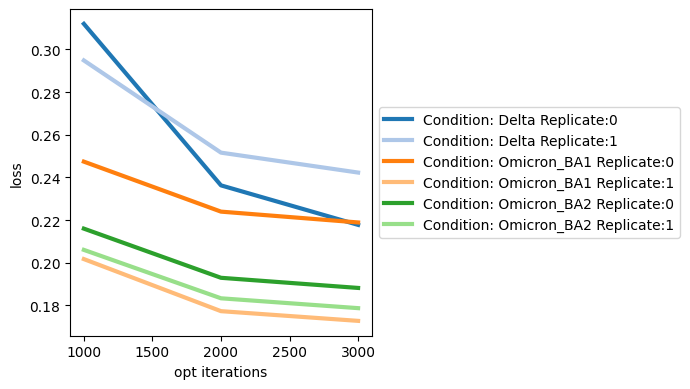

In [16]:
cmap=plt.get_cmap("tab20")


fig, ax = plt.subplots(1,figsize=[7,4])
for i, (model, model_row) in enumerate(models.iterrows()):
    ax.plot(
        [1000 * (s+1) for s in range(len(model_row.step_loss))],
        model_row.step_loss,
        c=cmap.colors[i],
        lw=3,
        label=f"Condition: {model_row.condition} Replicate:{model_row.replicate}"
    )

ax.set_ylabel("loss")
ax.set_xlabel("opt iterations")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

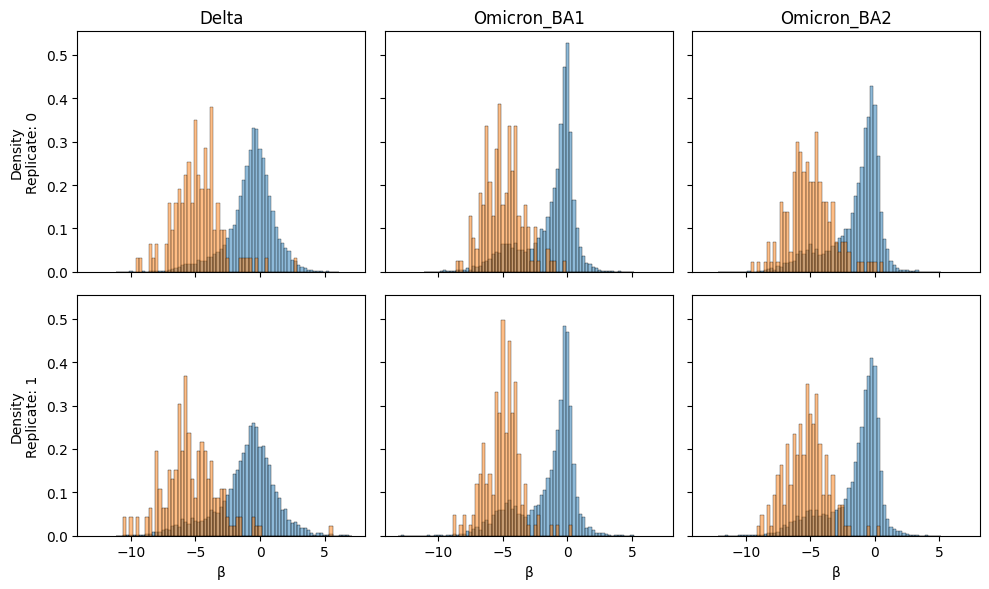

In [17]:

# for i, (model, model_row) in enumerate(models.iterrows()):
fig, ax = plt.subplots(2,3,figsize=[10,6], sharex=True, sharey=True)
for col, (condition, condition_models) in enumerate(models.groupby("condition")):
    for row, (replicate, replicate_models) in enumerate(condition_models.groupby("replicate")):
        if row == 0:
            ax[row, col].set_title(condition)
        if col == 0:
            ax[row, col].set_ylabel(f"Density\nReplicate: {replicate}")
            
#         print(replicate_models)
        replicate_models["model_3000"].values[0].plot_param_hist("β", ax=ax[row,col], show=False)
plt.tight_layout()
plt.show()
#     model_row.model_3000.plot_epistasis(alpha=0.1)
#         model_row.model_3000.plot_param_hist("β")

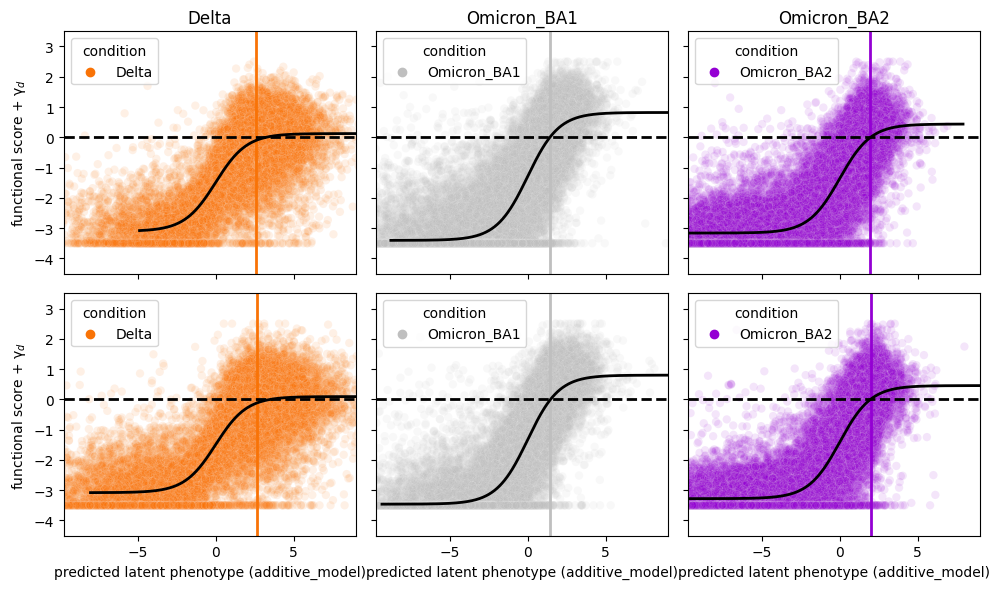

In [18]:

# for i, (model, model_row) in enumerate(models.iterrows()):
fig, ax = plt.subplots(2,3,figsize=[10,6], sharex=True, sharey=True)
for col, (condition, condition_models) in enumerate(models.groupby("condition")):
    for row, (replicate, replicate_models) in enumerate(condition_models.groupby("replicate")):
        if row == 0:
            ax[row, col].set_title(condition)
        if col == 0:
            ax[row, col].set_ylabel(f"Density\nReplicate: {replicate}")
            
#         print(replicate_models)
#         replicate_models["model_3000"].values[0].plot_param_hist("β", ax=ax[row,col], show=False)
        replicate_models["model_3000"].values[0].plot_epistasis(alpha=0.1, ax=ax[row,col], show=False)
    
plt.tight_layout()
plt.show()
#     model_row.model_3000.plot_epistasis(alpha=0.1)
#         model_row.model_3000.plot_param_hist("β")

In [36]:
fit_dict = {f"{row.replicate}-{row.condition}":row.model_3000 for _, row in models.iterrows()}
mut_df = multidms.utils.combine_replicate_muts(fit_dict,how="inner",times_seen_threshold=3)

In [20]:
mut_df

,wts,sites,muts,0-Delta_β,1-Delta_β,0-Omicron_BA1_β,1-Omicron_BA1_β,0-Omicron_BA2_β,1-Omicron_BA2_β,avg_β
mutation,,,,,,,,,,
M1I,M,1,I,-2.509346,-5.183149,-4.717206,-5.249604,-5.010637,-6.347744,-4.836281
F2L,F,2,L,0.695470,1.095539,0.402694,0.673661,-0.385884,0.429805,0.485214
V3A,V,3,A,0.110519,-0.024772,0.084359,0.028171,-0.054072,-0.113430,0.005129
V3F,V,3,F,-0.621172,0.185542,-0.675041,-0.548449,-0.635997,-0.430014,-0.454189
V3G,V,3,G,-0.314578,0.897483,0.006068,0.131336,0.077659,0.049073,0.141174
...,...,...,...,...,...,...,...,...,...,...
S1252R,S,1252,R,0.974202,0.386746,0.232415,0.573367,0.592692,0.625938,0.564227
S1252T,S,1252,T,-0.248973,-0.714395,-0.243054,-0.347725,-0.571046,-0.539059,-0.444042
S1252V,S,1252,V,0.444267,0.068158,0.370209,0.550719,0.312138,0.208330,0.325637


In [21]:
import seaborn as sns
%matplotlib inline

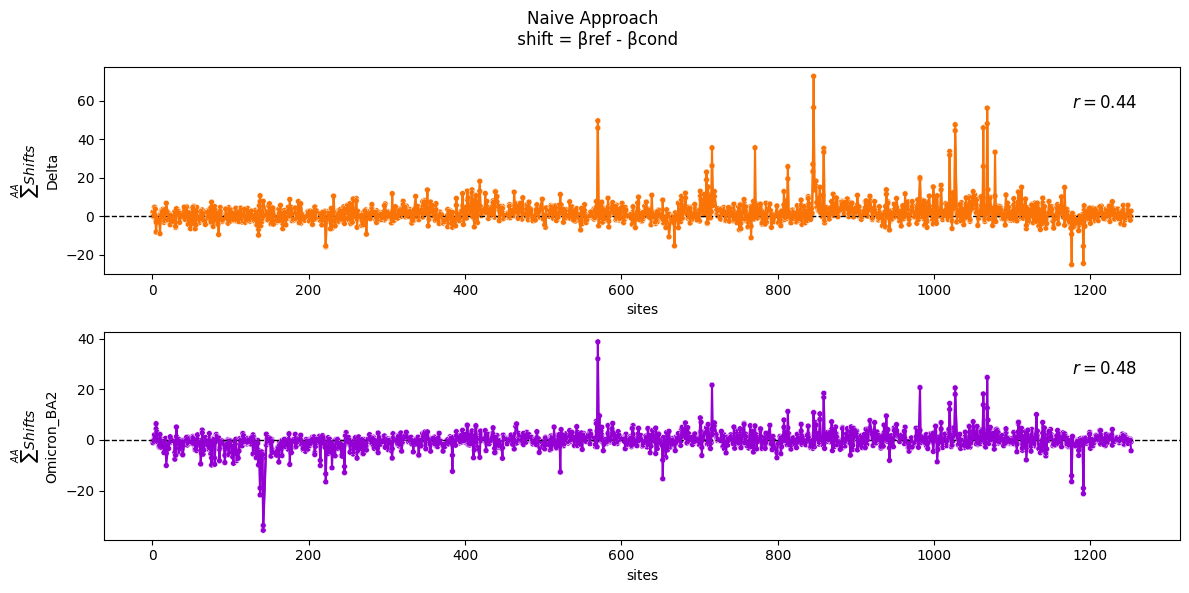

In [22]:
reference = "Omicron_BA1"
fig, ax = plt.subplots(2, figsize=[12,6])
# ax.axhline(0, color="k", ls="--", lw=1)
for i, condition in enumerate(["Delta", "Omicron_BA2"]):
    ax[i].axhline(0, color="k", ls="--", lw=1)
    
    for replicate in [0, 1]:
        reference_betas = mut_df[f"{replicate}-{reference}_β"]
        condition_betas = mut_df[f"{replicate}-{condition}_β"]
        mut_df[f"{replicate}-{condition}_S"] = condition_betas - reference_betas
        collapsed_mut_df = mut_df.groupby("sites").aggregate(onp.sum) 
        sns.lineplot(
            collapsed_mut_df, 
            x="sites", 
            y=f"{replicate}-{condition}_S", 
            ax = ax[i],
            color = cc[condition]
        )
        sns.scatterplot(
            collapsed_mut_df, 
            x="sites", 
            y=f"{replicate}-{condition}_S", 
            ax = ax[i],
            size=0.5,
            color=cc[condition],
            legend=False
        )
    
    ax[i].set_ylabel("$\sum^{AA} Shifts$"+"\n"+condition)
        
    corr = pearsonr(mut_df[f"0-{condition}_S"], mut_df[f"1-{condition}_S"])[0]
    ax[i].annotate(
        f"$r = {corr:.2f}$", 
        (0.9, 0.8), 
        xycoords="axes fraction", 
        fontsize=12
    )
fig.suptitle("Naive Approach \n shift = βref - βcond")
plt.tight_layout()
plt.show()

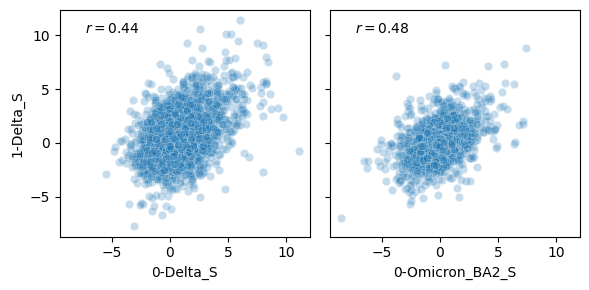

In [23]:
fig, ax = plt.subplots(1,2, figsize=[6,3], sharex=True, sharey=True)
# ax.axhline(0, color="k", ls="--", lw=1)
for i, condition in enumerate(["Delta", "Omicron_BA2"]):
    corr = pearsonr(mut_df[f"0-{condition}_S"], mut_df[f"1-{condition}_S"])[0]
    sns.scatterplot(mut_df, x=f"0-{condition}_S", y=f"1-{condition}_S", ax=ax[i], alpha=0.25)
    ax[i].annotate(
        f"$r = {corr:.2f}$", 
        (0.1, 0.9), 
        xycoords="axes fraction", 
        fontsize=10
    )
plt.tight_layout()
plt.show()

In [24]:
mut_df

,wts,sites,muts,0-Delta_β,1-Delta_β,0-Omicron_BA1_β,1-Omicron_BA1_β,0-Omicron_BA2_β,1-Omicron_BA2_β,avg_β,0-Delta_S,1-Delta_S,0-Omicron_BA2_S,1-Omicron_BA2_S
mutation,,,,,,,,,,,,,,
M1I,M,1,I,-2.509346,-5.183149,-4.717206,-5.249604,-5.010637,-6.347744,-4.836281,2.207859,0.066455,-0.293432,-1.098140
F2L,F,2,L,0.695470,1.095539,0.402694,0.673661,-0.385884,0.429805,0.485214,0.292775,0.421879,-0.788579,-0.243856
V3A,V,3,A,0.110519,-0.024772,0.084359,0.028171,-0.054072,-0.113430,0.005129,0.026161,-0.052943,-0.138430,-0.141601
V3F,V,3,F,-0.621172,0.185542,-0.675041,-0.548449,-0.635997,-0.430014,-0.454189,0.053870,0.733991,0.039044,0.118434
V3G,V,3,G,-0.314578,0.897483,0.006068,0.131336,0.077659,0.049073,0.141174,-0.320647,0.766147,0.071591,-0.082263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S1252R,S,1252,R,0.974202,0.386746,0.232415,0.573367,0.592692,0.625938,0.564227,0.741787,-0.186620,0.360278,0.052571
S1252T,S,1252,T,-0.248973,-0.714395,-0.243054,-0.347725,-0.571046,-0.539059,-0.444042,-0.005918,-0.366670,-0.327992,-0.191334
S1252V,S,1252,V,0.444267,0.068158,0.370209,0.550719,0.312138,0.208330,0.325637,0.074058,-0.482561,-0.058071,-0.342390


In [38]:
import seaborn as sns
sns.set_theme(font_scale=1.5, style='ticks', palette='colorblind')

# replicate_models = models.query("λ_lasso_shift == @chosen_lasso_strength")
# fit_dict = {row.replicate:row[model_name] for _, row in replicate_models.iterrows()}
# mut_df = multidms.utils.combine_replicate_muts(fit_dict, times_seen_threshold=3, how="inner")

rep0 = fit_dict[0]
for homolog in rep0.data.conditions:
    if homolog == rep0.data.reference:

        mut_df[f"β_{homolog}"] = mut_df.avg_β
    else:

        mut_df[f"β_{homolog}"] = mut_df.avg_β + mut_df[f"avg_S_{homolog}"]
        
    mut_df[f"β_{homolog}"] = mut_df.avg_β
    

mut_df.reset_index(inplace=True)

# Read in data
val_df = pd.read_csv('../data/spike_validation_data.csv')

# Restructure the data
val_dict = {
    key : []
    for key in [
        'mutation', 'fold_change', 'homolog', 'replicate',
        'predicted_beta'
    ]
}
validation_mutations = ['D142L', 'A419S', 'A570D', 'K854N', 'T1027I']
for i, row in val_df.iterrows():
    for mutation in validation_mutations:
        homolog = row['background'].replace('.', '')
        homolog = "Omicron_" + homolog if "BA" in homolog else homolog
#         print(homolog)
        val_dict['mutation'].append(mutation)
        val_dict['fold_change'].append(row[mutation])
        val_dict['homolog'].append(homolog)
        val_dict['replicate'].append(row['replicate'])

#         predicted_beta = float(mut_df[
#             mut_df['mutation'] == mutation
#         ][f'β_{homolog}'])
        predicted_beta = float(mut_df[
            mut_df['mutation'] == mutation
        ][f'β_{homolog}'])
        val_dict['predicted_beta'].append(predicted_beta)

val_df = pd.DataFrame(val_dict)
val_df['site'] = val_df['mutation'].apply(lambda x: int(x[1:-1]))
val_df['homolog'].replace('Omicron_BA1', 'BA.1', inplace=True)
val_df['homolog'].replace('Omicron_BA2', 'BA.2', inplace=True)
val_df.sort_values('site', inplace=True)
# val_df.head()

(fig, axs) = plt.subplots(
    nrows=2, ncols=3, sharex=True, sharey=True,
    figsize=[9,6]
)
axs = axs.reshape(-1)

for (i, mutation) in enumerate(validation_mutations):
    data = val_df[val_df['mutation'] == mutation]
    sns.scatterplot(
        x='predicted_beta', y='fold_change', data=data,
        hue='homolog', ax=axs[i], s=200, alpha=0.5,
        hue_order=['Delta', 'BA.1', 'BA.2']
    )
    axs[i].set(
        title=mutation, xlabel='', ylabel='',
        yscale='log', ylim=[1e-5,2], yticks=[1, 1e-2, 1e-4]
    )
    axs[i].grid()
    axs[i].get_legend().remove()

fig.text(
    0.51, -0.06, 'inferred latent effect of mutation\n(= $β_m + s_{m,d}$)',
    ha='center'
)
fig.text(
    -0.01, 0.51, 'fold change in viral titer (mutant : WT)',
    va='center', rotation='vertical'
)
#axs[0].set(ylabel='observed fold change\n(validation experiment)')
#axs[1].legend(loc='lower right')
axs[5].set_visible(False)
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=[0.91,0.4])
plt.tight_layout()
sns.despine()
plt.show()
fig.savefig(f"{OUTDIR}/validation_{chosen_lasso_strength}.pdf")

,wts,muts,Delta-0_β,Delta-1_β,Omicron_BA1-0_β,Omicron_BA1-1_β,Omicron_BA2-0_β,Omicron_BA2-1_β,avg_β
sites,,,,,,,,,
1,M,I,-7.090170,-5.183149,-4.717206,-5.249604,-5.010637,-6.347744,-5.599752
2,F,L,0.259331,1.095539,0.402694,0.673661,-0.385884,0.429805,0.412524
3,VVVVVV,AFGILM,-2.035400,4.114728,-1.652786,-0.676428,-0.795006,1.367771,0.053813
4,FFF,ILS,-2.730357,3.835778,0.282830,0.033331,0.160505,-0.637428,0.157443
5,LLLLLLLLLLLLLLLLL,ACDEFGHIMNPRSTVWY,-11.646478,-12.991970,-6.611314,-9.989218,-2.226651,-3.558555,-7.837365
...,...,...,...,...,...,...,...,...,...
1248,CCCCC,FRSWY,-4.231782,-3.574528,-2.843124,-2.447964,-2.485136,-3.482811,-3.177557
1249,SSSS,AFPY,3.900556,1.612040,-0.991298,-0.722223,-0.737537,-0.360710,0.450138
1250,CCCCCC,FGRSWY,1.281755,-2.542530,-1.238952,-1.109663,-1.913675,-1.522746,-1.174302
